# <font color='#922B21'><b><center> BOOKING CANCELLATIONS </font> </b> </center>

## <font color='#7D3C98'>Table of Contents</font>

1. [Problem Statement](#1)
2. [Modules](#2)
3. [Helper Functions](#3)
4. [Loading Data and Pre-processing](#4)
5. [Model Selection](#5)
6. [Hyperparameter Tunnig](#6)
7. [Making predictions](#7)


<a name="1"></a>
## <font color='red'> <b> 1. Problem Statement </font> </b>

We want to predict booking cancellations.

<a name="2"></a>
## <font color='red'> <b> 2. Modules </font> </b>

In [58]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import warnings
warnings.filterwarnings('ignore')

In [59]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns

import keras_tuner

<a name="3"></a>
## <font color='red'> <b> 3. Helper Functions </font> </b>

In [102]:
# confussion matrix
def plot_confusion_matrix(y_test,y_pred,labels,figsize=(8,6)):
    plt.figure(figsize=figsize)
    confusion_mtx = tf.math.confusion_matrix(y_test,y_pred)
    sns.heatmap(confusion_mtx,
                xticklabels=labels,
                yticklabels=labels,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()
    
    

# plot history
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots

    # Plot for Binary Crossentropy
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Binary Crossentropy')
    axs[0].plot(hist['epoch'], hist['loss'], label='Train Error')
    axs[0].plot(hist['epoch'], hist['val_loss'], label='Val Error')
    axs[0].legend()

    # Plot for Accuracy
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    axs[1].plot(hist['epoch'], hist['val_accuracy'], label='Val Accuracy')
    axs[1].legend()

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()


    
    

<a name="4"></a>
## <font color='red'> <b> 4. Loading data and pre-processing </font> </b>

### Loading and exploring data

In [77]:
df = pd.read_csv('data/BookingCancellation.csv')

df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01/07/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01/07/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,02/07/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,02/07/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,03/07/2015


In [78]:
df.shape

(119390, 32)

In [79]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [80]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

### Pre-processing

We are going to:
   - Drop the columns "company" and "agent" (due to a high number of null values).
   - Replace the missing values in "Country" with "NA".
   - Normalize numerical variables.
   - Convert categorical variables into one-hot encoding except for "arrival_date_month" (we're gonna use label encoder)


In [81]:
# drop columns
df.drop(['company', 'agent'], axis=1, inplace=True)

In [82]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [83]:
# separation between features and labels
X = df.copy()
y = X.pop('is_canceled')

In [84]:
# label encoding for arrival_date_month
X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

In [85]:
# numerical features
features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]

# categorical features
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

In [86]:
# for numerical features
transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)

# for categorical features
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),# there are a few missing values in country
    OneHotEncoder(handle_unknown='ignore'),
)


# make_column_:transfoerm -> Construct a ColumnTransformer from the given transformers.
preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

    

In [87]:
# train/tets spli; stratify - make sure classes are evenlly represented across splits
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, stratify=y, train_size=0.75)

In [88]:
X_train = preprocessor.fit_transform(X_train) # fit and transform
X_test = preprocessor.transform(X_test) # only transform

<a name="5"></a>
## <font color='red'> <b> 5. Model Selection </font> </b>

We're going to compare two models and choose the best one for fine-tuning

### Model 1

In [89]:
def build_model_one(input_shape):
    model = keras.Sequential([
        layers.Dense(20,activation='relu',input_shape=input_shape),
        layers.Dense(20,activation='relu'),
        layers.Dense(20,activation='relu'),
        layers.Dense(1,activation='sigmoid'), # 2 classes
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [90]:
model_one = build_model_one([X_train.shape[1]])
model_one.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 20)                1280      
                                                                 
 dense_22 (Dense)            (None, 20)                420       
                                                                 
 dense_23 (Dense)            (None, 20)                420       
                                                                 
 dense_24 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2141 (8.36 KB)
Trainable params: 2141 (8.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [91]:
early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,
    )


history_one = model_one.fit(
    X_train,y_train,
    validation_split=0.2,
    batch_size=512,
    epochs=20,
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/20
140/140 - 1s - loss: 0.5460 - accuracy: 0.7243 - val_loss: 0.4519 - val_accuracy: 0.7942 - 882ms/epoch - 6ms/step
Epoch 2/20
140/140 - 0s - loss: 0.4306 - accuracy: 0.8025 - val_loss: 0.4259 - val_accuracy: 0.8043 - 201ms/epoch - 1ms/step
Epoch 3/20
140/140 - 0s - loss: 0.4138 - accuracy: 0.8101 - val_loss: 0.4161 - val_accuracy: 0.8080 - 207ms/epoch - 1ms/step
Epoch 4/20
140/140 - 0s - loss: 0.4057 - accuracy: 0.8121 - val_loss: 0.4123 - val_accuracy: 0.8085 - 202ms/epoch - 1ms/step
Epoch 5/20
140/140 - 0s - loss: 0.4003 - accuracy: 0.8138 - val_loss: 0.4061 - val_accuracy: 0.8109 - 205ms/epoch - 1ms/step
Epoch 6/20
140/140 - 0s - loss: 0.3962 - accuracy: 0.8152 - val_loss: 0.4030 - val_accuracy: 0.8129 - 204ms/epoch - 1ms/step
Epoch 7/20
140/140 - 0s - loss: 0.3923 - accuracy: 0.8167 - val_loss: 0.3994 - val_accuracy: 0.8124 - 197ms/epoch - 1ms/step
Epoch 8/20
140/140 - 0s - loss: 0.3895 - accuracy: 0.8172 - val_loss: 0.3979 - val_accuracy: 0.8138 - 208ms/epoch - 1ms/step


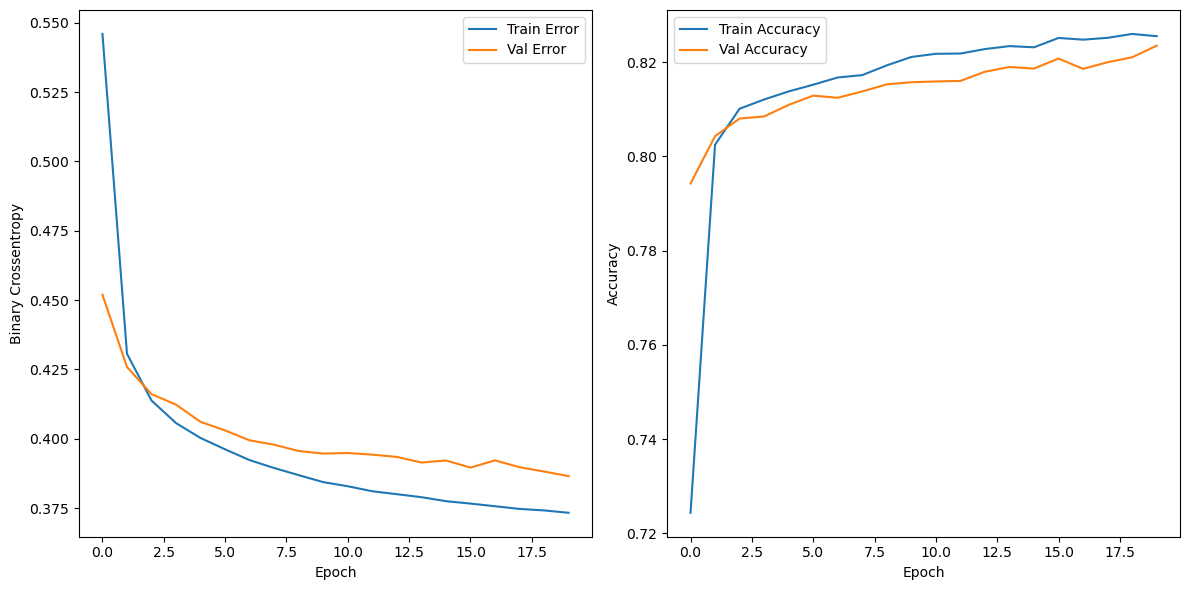

In [97]:
plot_history(history_one)

In [92]:
scores_one = model_one.evaluate(X_test, y_test)

933/933 [==============================] - 1s 877us/step - loss: 0.3807 - accuracy: 0.8240


933/933 [==============================] - 1s 787us/step


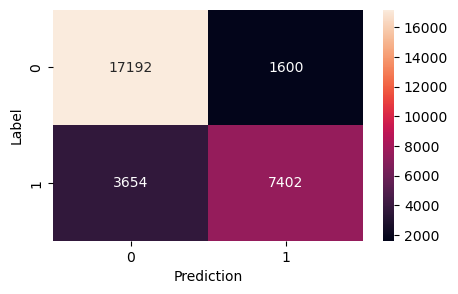

In [120]:
# confussion matrix

y_preds = model_one.predict(X_test)

confusion_mtx = plot_confusion_matrix(y_test, tf.round(y_preds),['0','1'],(5,3))

We can see our biggest problem are "False Negatives."

### Model 2

In [111]:
def build_model_two(input_shape):
    model = keras.Sequential([
        layers.BatchNormalization(input_shape=input_shape),
        layers.Dense(256,activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.3),
        layers.Dense(256,activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.3),
        layers.Dense(1,activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [112]:
model_two = build_model_two([X_train.shape[1]])
model_two.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Bat  (None, 63)                252       
 chNormalization)                                                
                                                                 
 dense_31 (Dense)            (None, 256)               16384     
                                                                 
 batch_normalization_7 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_8 (Bat  (None, 256)              

In [113]:
early_stopping = keras.callbacks.EarlyStopping(
        patience=20,
        min_delta=0.001,
        restore_best_weights=True,
    )


history_two = model_two.fit(
        X_train,y_train,
        validation_split=0.2,
        batch_size=512,
        epochs=20,
        callbacks=[early_stopping],
        verbose=0
)

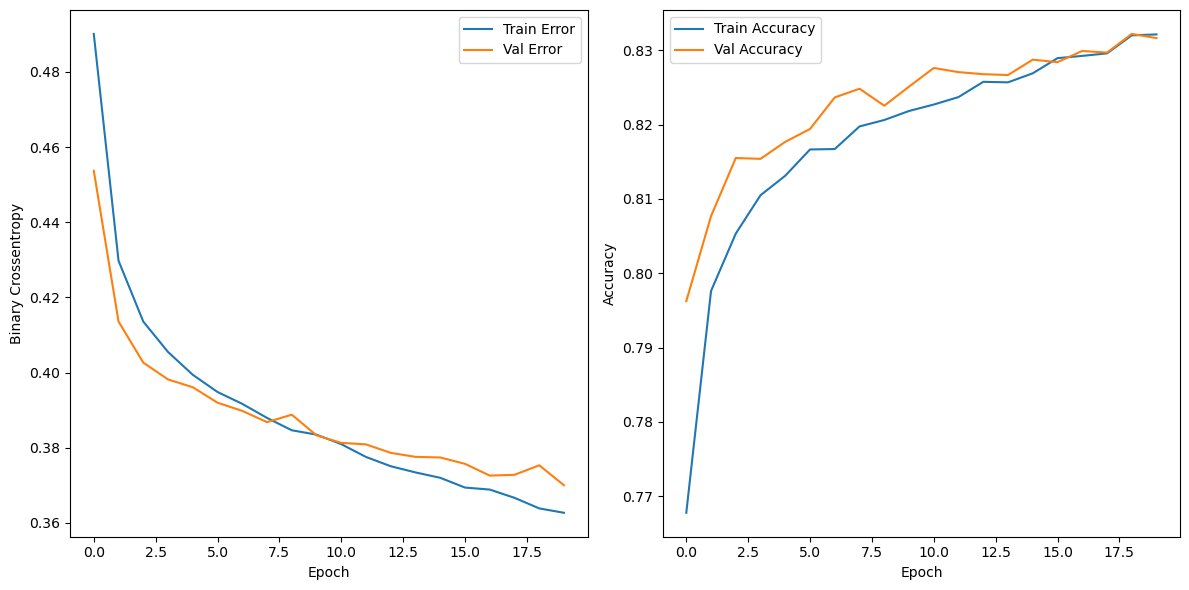

In [114]:
plot_history(history_two)

In [115]:
scores_two = model_two.evaluate(X_test, y_test)

933/933 [==============================] - 1s 1ms/step - loss: 0.3629 - accuracy: 0.8346


933/933 [==============================] - 1s 1ms/step


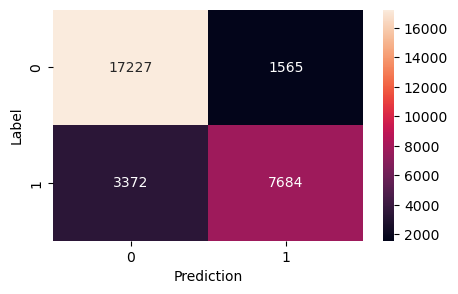

In [119]:
y_preds = model_two.predict(X_test)

confusion_mtx = plot_confusion_matrix(y_test, tf.round(y_preds),['0','1'],(5,3))

### <font color='#5B2C6F'> Model Selection </font>

Depending on the problem, one metric (precision, recall, accuracy, f1-score) may be more relevant than another, and we would choose the model primarily based on it. In this case, we won't complicate things and we'll do it based on accuracy.

<b> Note </b> Other considerations when choosing the model are:

- Model Complexity

- Training and Prediction Time

- Interpretability of Results

- Resource Requirements

- Robustness and Stability.

- Scalability

In [121]:
if scores_two[1] > scores_one[1]:
    print("Best model is Model 2")
else:
    print("Best model is Model 1")

Best model is Model 2


<a name="6"></a>
## <font color='red'> <b> 6. Hyperparameter tunnig </font> </b>

We are going to use Keras tuner.

In [123]:
def build_model(hp):
    model = keras.Sequential([
        layers.BatchNormalization(),
        layers.Dense(hp.Choice('units1', [256, 512]),activation='relu'), #units1
        layers.BatchNormalization(),
        layers.Dropout(hp.Choice('rate1', [0.1, 0.3,0.5])),
        layers.Dense(hp.Choice('units2', [256, 512]),activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(hp.Choice('rate2', [0.1, 0.3,0.5])),
        layers.Dense(1,activation='sigmoid'),
    ])
                     
    lr = hp.Choice("learning_rate",values=[1e-1, 1e-2, 1e-3])
    opt = keras.optimizers.Adam(learning_rate=lr)
    # compile the model
    model.compile(optimizer=opt, loss="binary_crossentropy",
        metrics=["accuracy"])
                     
    return model

In [124]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

In [125]:
tuner.search(X_train, y_train, epochs=5,validation_split=0.2) #validation_data=(X_test, y_test)

Trial 5 Complete [00h 00m 34s]
val_loss: 0.408965528011322

Best val_loss So Far: 0.39682793617248535
Total elapsed time: 00h 04m 38s
INFO:tensorflow:Oracle triggered exit


In [127]:
tuner.results_summary(1)

Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
units1: 256
rate1: 0.1
units2: 512
rate2: 0.3
learning_rate: 0.001
Score: 0.39682793617248535


In [ ]:
# re-training with the best hyperparameters

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
final_model = tuner.hypermodel.build(best_hps)

final_history = final_model.fit(X_train, y_train, epochs=20,validation_split=0.2,verbose=0)

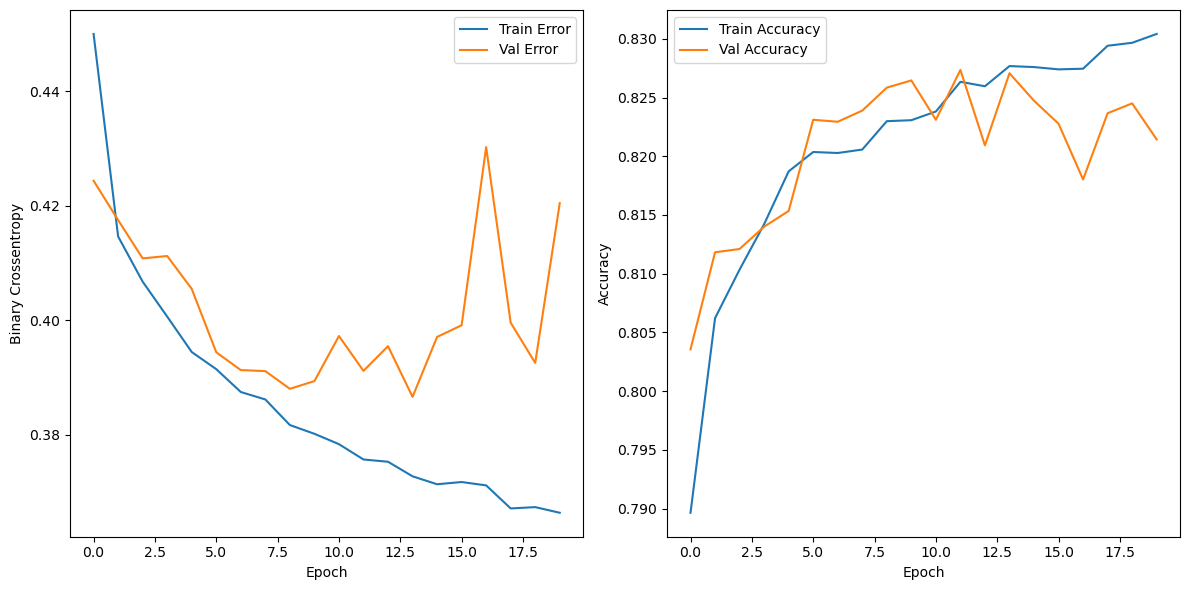

In [130]:
plot_history(final_history)

933/933 [==============================] - 1s 1ms/step


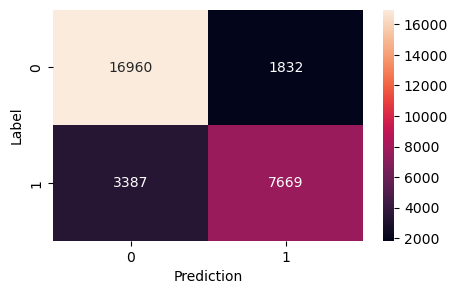

In [132]:
y_preds = final_model.predict(X_test)

confusion_mtx = plot_confusion_matrix(y_test, tf.round(y_preds),['0','1'],(5,3))

In [133]:
scores = final_model.evaluate(X_test, y_test)

933/933 [==============================] - 1s 1ms/step - loss: 0.4173 - accuracy: 0.8251


<a name="7"></a>
## <font color='red'> <b> 7. Making predictions </font> </b>

Let's see some predictions with the test set.

In [157]:
# show the numbers without scientific notation

# preds
preds = final_model.predict(X_test[:15]) # first fifteen
preds


1/1 [==============================] - 0s 17ms/step


array([[0.24366376],
       [0.08952308],
       [0.25534275],
       [0.02723125],
       [0.2622089 ],
       [0.14366347],
       [0.11417899],
       [0.00021761],
       [0.07611921],
       [0.76895547],
       [0.99983466],
       [0.7729577 ],
       [0.13400038],
       [0.08174872],
       [0.6209122 ]], dtype=float32)

We can observe that our outputs are probabilities, specifically representing the likelihood of a booking cancellation. Now, we will determine whether the booking cancels or not, based on the most probable class:

In [158]:
pred_classes = (preds > 0.5).astype(int)
pred_classes



array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1]])